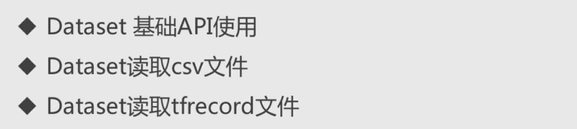

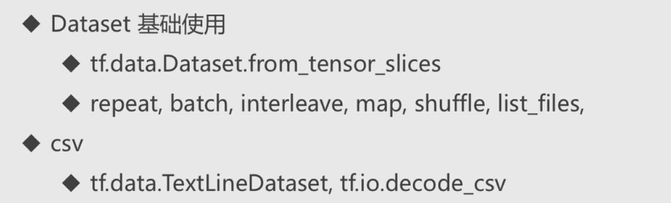

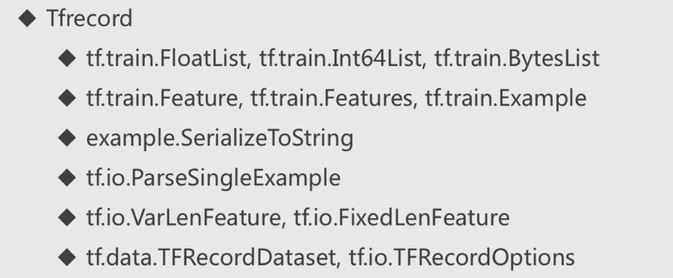

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os, sys, time

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

print(tf.__version__)
print(sys.version_info)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


### from_tensor_slices

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(([1.], ['one']))
print(dataset)

<TensorSliceDataset shapes: ((), ()), types: (tf.float32, tf.string)>


In [5]:
dataset = tf.data.Dataset.from_tensor_slices({'one': [1.]})
print(dataset)

<TensorSliceDataset shapes: {one: ()}, types: {one: tf.float32}>


In [6]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))
print(dataset)

<TensorSliceDataset shapes: (), types: tf.int32>


In [7]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [8]:
# repeat, batch
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [9]:
# interleave
# cycle_length: 并行处理；block_length：每次取多长的block数据
dataset2 = dataset.interleave(
    lambda v: tf.data.Dataset.from_tensor_slices(v),
    cycle_length=5,
    block_length=5,
)

### csv

#### 生成

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

x_train_all, x_test, y_train_all,  y_test = train_test_split(
    housing.data, housing.target, random_state=1)
x_train, x_valid, y_train, y_test = train_test_split(
    x_train_all, y_train_all, random_state=2)

In [20]:
output_dir = "generate_csv"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def save_csv(output_dir, data, name_prefix, header=None, n_parts=10):
    path_pattern = os.path.join(output_dir, "{}_{:02d}.csv")
    filenames = []
    for idx, row_idx in enumerate(
        np.array_split(np.arange(len(data)), n_parts)):
        csv = path_pattern.format(name_prefix, idx)
        filenames.append(csv)
        with open(csv, 'wt', encoding='utf-8') as f:
            if header is not None:
                f.write(header + '\n')
            for r_idx in row_idx:
                f.write(','.join(
                    [repr(col) for col in data[r_idx]]
                ))
                f.write('\n')
    return filenames

In [21]:
train_data = np.c_[x_train, y_train]
header = housing.feature_names + ["Value"] 
header_str = ",".join(header)

train_file = save_csv(output_dir, train_data, "train", header_str, n_parts=20)

#### 读取

In [23]:
# 1
filename_data = tf.data.Dataset.list_files(train_file)
# 2  skip header line
n_readers = 5
dataset = filename_data.interleave(
    lambda filename: tf.data.TextLineDataset(filename).skip(1),
    cycle_length=n_readers
)

In [24]:
for line in dataset.take(3):
    print(line)

tf.Tensor(b'2.325,32.0,6.344827586206897,1.0886699507389161,562.0,2.768472906403941,39.78,-122.16,0.696', shape=(), dtype=string)
tf.Tensor(b'1.0219,29.0,2.921681780708986,1.1409727947238253,3323.0,2.7394888705688376,34.03,-118.29,2.583', shape=(), dtype=string)
tf.Tensor(b'2.3542,39.0,3.861635220125786,1.0943396226415094,538.0,3.3836477987421385,34.0,-118.46,2.357', shape=(), dtype=string)


In [25]:
# 3  parse
sample_str = '1, 2, 3, 4, 5'
record_defaults = [tf.constant(0, dtype=tf.int32)] * 5
# record_defaults = [
#     tf.constant(0, dtype=tf.int32),
#     0,
#     np.nan,
#     "hello",
#     tf.constant([])
# ]

parsed = tf.io.decode_csv(sample_str, record_defaults)
print(parsed)

[<tf.Tensor: id=106, shape=(), dtype=int32, numpy=1>, <tf.Tensor: id=107, shape=(), dtype=int32, numpy=2>, <tf.Tensor: id=108, shape=(), dtype=int32, numpy=3>, <tf.Tensor: id=109, shape=(), dtype=int32, numpy=4>, <tf.Tensor: id=110, shape=(), dtype=int32, numpy=5>]


In [26]:
# 完整流程
def parse_csv_line(line, n_fields=9):
    defs = [tf.constant(np.nan)] * n_fields  # 解析为float
    parse_fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parse_fields[0: -1])
    y = tf.stack(parse_fields[-1: ])
    return x, y


def csv_reader_dataset(filenames,
                       n_readers=5,
                       batch_size=32,
                       n_parse_threads=5,
                       shuffle_buffer=10000):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),
        cycle_length=n_readers
    )
    dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(parse_csv_line, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

train_set = csv_reader_dataset(train_file)

In [30]:
import pprint

for x_batch, y_batch in train_set.take(1):
    pprint.pprint(x_batch)
    pprint.pprint(y_batch)

<tf.Tensor: id=224, shape=(32, 8), dtype=float32, numpy=
array([[ 1.1860300e+01,  3.9000000e+01,  7.9111109e+00,  9.8412699e-01,
         8.0800000e+02,  2.5650795e+00,  3.7820000e+01, -1.2222000e+02],
       [ 1.3333000e+00,  3.0000000e+01,  8.5714283e+00,  2.1587303e+00,
         1.2200000e+02,  1.9365079e+00,  3.4220001e+01, -1.1552000e+02],
       [ 2.4375000e+00,  4.7000000e+01,  4.8961539e+00,  1.0153847e+00,
         1.1930000e+03,  4.5884614e+00,  3.4049999e+01, -1.1819000e+02],
       [ 1.1346000e+00,  4.2000000e+01,  3.5921052e+00,  1.0219299e+00,
         8.9900000e+02,  3.9429824e+00,  3.3930000e+01, -1.1825000e+02],
       [ 3.9375000e+00,  3.5000000e+01,  5.4652405e+00,  9.7860962e-01,
         6.2800000e+02,  3.3582888e+00,  3.4060001e+01, -1.1793000e+02],
       [ 2.3375001e+00,  1.7000000e+01,  4.7708192e+00,  1.0227116e+00,
         3.0560000e+03,  2.1032348e+00,  3.6820000e+01, -1.1976000e+02],
       [ 4.8916998e+00,  4.5000000e+01,  5.9180889e+00,  1.1296928e+00,
 

model训练时，传入dataset为数据输入，指定steps_per_epoch，因为不知道多少为一个epoch

### record

tf.data.Example  
        -> tf.data.Features : 字典，数据类型为tf内置类型

In [41]:
strings = [s.encode('utf-8') for s in ['a', 'b', 'c']]
strings_bytelist = tf.train.BytesList(value=strings)

floatlist = tf.train.FloatList(value=[1., 2., 3., 4.,])

intlist = tf.train.Int64List(value=[1, 2, 3, 4])

features = tf.train.Features(
    feature={
        "str": tf.train.Feature(bytes_list=strings_bytelist),
        "float": tf.train.Feature(float_list=floatlist),
        "int": tf.train.Feature(int64_list=intlist)
    })

examples = tf.train.Example(features=features)
serialized_example = examples.SerializeToString()  # 序列化压缩

output_dir = "tfrecord"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
filename = "test.tfrecords"
filename_fullpath = os.path.join(output_dir, filename)
with tf.io.TFRecordWriter(filename_fullpath) as writer:
    for i in range(3):
        writer.write(serialized_example)

In [45]:
# 读取
# dataset = tf.data.TFRecordDataset([filename_fullpath])
# 读取 + 解析
#   注意FixedLenFeature([4]），[4]--4维要指定
parse_features = {
    "str": tf.io.VarLenFeature(dtype=tf.string),
    "float": tf.io.VarLenFeature(dtype=tf.float32),
    "int": tf.io.FixedLenFeature([4], dtype=tf.int64)
}

dataset = tf.data.TFRecordDataset([filename_fullpath])
for serialized_example_tensor in dataset:
    example = tf.io.parse_single_example(
        serialized_example_tensor,
        parse_features)
    strings = tf.sparse.to_dense(example["str"],
                                 default_value=b"")
    for s in strings:
        print(s.numpy().decode("UTF-8"))
    print(example)

a
b
c
{'float': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002319A023B70>, 'str': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002319A0231D0>, 'int': <tf.Tensor: id=371, shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>}
a
b
c
{'float': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002319A01ABA8>, 'str': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002319A01A780>, 'int': <tf.Tensor: id=394, shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>}
a
b
c
{'float': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002319A023320>, 'str': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000023199691860>, 'int': <tf.Tensor: id=417, shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>}


In [ ]:
# zip文件
filename_fullpath_zip = filename_fullpath + '.zip'
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter(filename_fullpath_zip) as writer:
    for i in range(3):
        writer.write(serialized_example)

ERROR! Session/line number was not unique in database. History logging moved to new session 2626


In [ ]:
dataset = tf.data.TFRecordDataset([filename_fullpath_zip], compression_type='GZIP')